In [140]:
%load_ext watermark
%watermark -v -p numpy,scipy,matplotlib,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.5.5
IPython 6.3.0

numpy 1.14.2
scipy 1.0.1
matplotlib 2.2.2
tensorflow 1.7.0


**9장 – 텐서플로 시작하기**

_이 노트북은 9장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 계산 그래프 만들고 실행하기

In [3]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [4]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [5]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [6]:
sess.close()

In [7]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

In [8]:
result

42

In [9]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()

In [10]:
result

42

In [11]:
init = tf.global_variables_initializer()

In [12]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

42


In [13]:
sess.close()

In [14]:
result

42

# 그래프 다루기

In [15]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [16]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [17]:
x2.graph is tf.get_default_graph()

False

In [18]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [19]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# 선형 회귀

## 정규방정식을 사용해서

In [20]:
import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [21]:
theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952334e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0338000e-06],
       [-3.7813708e-03],
       [-4.2348403e-01],
       [-4.3721911e-01]], dtype=float32)

넘파이와 비교

In [22]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


사이킷런과 비교

In [23]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## 배치 경사 하강법을 사용해서

경사 하강법은 먼저 특성 벡터의 스케일을 조정해야 합니다. 텐서플로를 사용해 할 수 있지만 그냥 여기서는 사이킷런을 사용하겠습니다.

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [25]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### 수동으로 그래디언트 계산하기

In [26]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

에포크 0 MSE = 9.161542
에포크 100 MSE = 0.7145004
에포크 200 MSE = 0.56670487
에포크 300 MSE = 0.5555718
에포크 400 MSE = 0.5488112
에포크 500 MSE = 0.5436363
에포크 600 MSE = 0.5396291
에포크 700 MSE = 0.5365092
에포크 800 MSE = 0.53406775
에포크 900 MSE = 0.5321473


In [27]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614529 ],
       [-0.6375279 ]], dtype=float32)

### 자동미분 사용하기

`gradients = ...` 라인만 빼고 위와 동일합니다:

In [28]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [29]:
gradients = tf.gradients(mse, [theta])[0]

In [30]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

에포크 0 MSE = 9.161542
에포크 100 MSE = 0.71450037
에포크 200 MSE = 0.56670487
에포크 300 MSE = 0.5555718
에포크 400 MSE = 0.54881126
에포크 500 MSE = 0.5436363
에포크 600 MSE = 0.53962916
에포크 700 MSE = 0.5365092
에포크 800 MSE = 0.53406775
에포크 900 MSE = 0.5321473
best_theta:
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.3477088 ]
 [ 0.36178365]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


`a`와 `b`에 대한 다음 함수의 편도함수를 어떻게 구할 수 있나요?

In [31]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [32]:
my_func(0.2, 0.3)

-0.21253923284754914

In [33]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

$a=0.2$와 $b=0.3$일 때 함수 값을 계산하고 그 다음 $a$와 $b$에 대한 편미분을 구합니다:

In [34]:
with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388495, 0.19671397]


### `GradientDescentOptimizer` 사용하기

In [35]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [36]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [37]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

에포크 0 MSE = 9.161542
에포크 100 MSE = 0.7145004
에포크 200 MSE = 0.56670487
에포크 300 MSE = 0.5555718
에포크 400 MSE = 0.54881126
에포크 500 MSE = 0.5436363
에포크 600 MSE = 0.53962916
에포크 700 MSE = 0.5365092
에포크 800 MSE = 0.53406775
에포크 900 MSE = 0.5321473
best_theta:
[[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.3477088 ]
 [ 0.36178365]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


### 모멘텀 옵티마이저 사용하기

In [38]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [39]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [40]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [41]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("best_theta:")
print(best_theta)

best_theta:
[[ 2.068558  ]
 [ 0.82962847]
 [ 0.11875335]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450249]
 [-0.03932662]
 [-0.8998645 ]
 [-0.8705207 ]]


# 훈련 알고리즘에 데이터 주입하기

## 플레이스홀더 노드

In [42]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)

[[6. 7. 8.]]


In [43]:
print(B_val_2)

[[ 9. 10. 11.]
 [12. 13. 14.]]


## 미니배치 경사 하강법

In [44]:
n_epochs = 1000
learning_rate = 0.01

In [45]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [46]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [47]:
n_epochs = 10

In [48]:
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [49]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [50]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255152],
       [-0.31211877],
       [ 0.38510376],
       [ 0.00434168],
       [-0.0123295 ],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# 모델의 저장과 복원

In [51]:
reset_graph()

n_epochs = 1000                                                                       # 책에는 없습니다.
learning_rate = 0.01                                                                  # 책에는 없습니다.

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # 책에는 없습니다.
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # 책에는 없습니다.
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # 책에는 없습니다.
error = y_pred - y                                                                    # 책에는 없습니다.
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # 책에는 없습니다.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # 책에는 없습니다.
training_op = optimizer.minimize(mse)                                                 # 책에는 없습니다.

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("에포크", epoch, "MSE =", mse.eval())                                # 책에는 없습니다.
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

에포크 0 MSE = 9.161542
에포크 100 MSE = 0.7145004
에포크 200 MSE = 0.56670487
에포크 300 MSE = 0.5555718
에포크 400 MSE = 0.54881126
에포크 500 MSE = 0.5436363
에포크 600 MSE = 0.53962916
에포크 700 MSE = 0.5365092
에포크 800 MSE = 0.53406775
에포크 900 MSE = 0.5321473


In [52]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.3477088 ],
       [ 0.36178365],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # 책에는 없습니다.

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [54]:
np.allclose(best_theta, best_theta_restored)

True

`theta`를 `"weights"`와 같은 다른 이름으로 저장하고 복원하는 Saver 객체를 원할 경우엔:

In [55]:
saver = tf.train.Saver({"weights": theta})

기본적으로 Saver 객체는 `.meta` 확장자를 가진 두 번째 파일에 그래프 구조도 저장합니다. `tf.train.import_meta_graph()` 함수를 사용하여 그래프 구조를 복원할 수 있습니다. 이 함수는 저장된 그래프를 기본 그래프로 로드하고 상태(즉, 변수 값)를 복원할 수 있는 `Saver` 객체를 반환합니다:

In [56]:
reset_graph()
# 빈 그래프로 시작합니다

saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # 그래프 구조를 로드합니다.
theta = tf.get_default_graph().get_tensor_by_name("theta:0") # 책에는 없습니다.

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # 그래프 상태를 로드합니다.
    best_theta_restored = theta.eval() # 책에는 없습니다.

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [57]:
np.allclose(best_theta, best_theta_restored)

True

이를 사용하면 그래프를 만든 파이썬 코드가 없이도 미리 훈련된 모델을 임포트할 수 있습니다. 모델을 저장하고 변경할 때도 매우 편리합니다. 이전에 저장된 모델을 구축한 코드의 버전을 찾지 않아도 로드할 수 있습니다.

# 그래프 시각화
## 쥬피터에서

In [58]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """graph_def에서 큰 상수 값은 제외시킵니다."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """텐서플로 그래프 나타내기"""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [59]:
show_graph(tf.get_default_graph())

## 텐서보드 사용하기

In [60]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [61]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [62]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [63]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [64]:
with tf.Session() as sess:                                                        # 책에는 없습니다.
    sess.run(init)                                                                # 책에는 없습니다.

    for epoch in range(n_epochs):                                                 # 책에는 없습니다.
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # 책에는 없습니다.

In [65]:
file_writer.close()

In [66]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255152],
       [-0.31211877],
       [ 0.38510376],
       [ 0.00434168],
       [-0.0123295 ],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# 이름 범위

In [67]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [68]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [69]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [70]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("best_theta:")
print(best_theta)

best_theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255152]
 [-0.31211877]
 [ 0.38510376]
 [ 0.00434168]
 [-0.0123295 ]
 [-0.83376896]
 [-0.8030471 ]]


In [71]:
print(error.op.name)

loss/sub


In [72]:
print(mse.op.name)

loss/mse


In [73]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# 모듈화

중복이 많습니다:

In [74]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

relu() 함수를 사용해 더 나아졌습니다:

In [75]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [76]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

이름 범주를 사용하면 훨씬 더 낫습니다:

In [77]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # 책에는 없습니다.
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    # 책에는 없습니다.
        b = tf.Variable(0.0, name="bias")                             # 책에는 없습니다.
        z = tf.add(tf.matmul(X, w), b, name="z")                      # 책에는 없습니다.
        return tf.maximum(z, 0., name="max")                          # 책에는 없습니다.

In [78]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

## 변수 공유

`threshold` 변수를 공유하는 기본적인 방법은 `relu()` 함수 밖에서 정의한 후 매개변수를 통해 전달하는 것입니다:

In [79]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # 책에는 없습니다.
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # 책에는 없습니다.
        b = tf.Variable(0.0, name="bias")                           # 책에는 없습니다.
        z = tf.add(tf.matmul(X, w), b, name="z")                    # 책에는 없습니다.
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [80]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # 책에는 없습니다.
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # 책에는 없습니다.
        b = tf.Variable(0.0, name="bias")                           # 책에는 없습니다.
        z = tf.add(tf.matmul(X, w), b, name="z")                    # 책에는 없습니다.
        return tf.maximum(z, relu.threshold, name="max")

In [81]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [82]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [83]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [84]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [85]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # 책에는 없습니다.
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # 책에는 없습니다.
        b = tf.Variable(0.0, name="bias")                           # 책에는 없습니다.
        z = tf.add(tf.matmul(X, w), b, name="z")                    # 책에는 없습니다.
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [86]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

In [87]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # 공유 변수를 만든 후
    scope.reuse_variables()  # 재사용합니다.
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

In [88]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # 책에는 없습니다.
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # 책에는 없습니다.
    b = tf.Variable(0.0, name="bias")                           # 책에는 없습니다.
    z = tf.add(tf.matmul(X, w), b, name="z")                    # 책에는 없습니다.
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [89]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

# 추가 내용

In [90]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


첫 번째 `variable_scope()` 블럭은 이름이 `my_scope/x`인 공유 변수 `x0`를 만듭니다. 공유 변수 이외의 모든 연산에 대해서는 (공유되지 않는 변수를 포함하여) 변수 범위가 일반적인 이름 범위처럼 작동합니다. 그래서 두 변수 `x1`과 `x2`에 접두사 `my_scope/`가 붙습니다. 하지만 텐서플로는 이름을 고유하게 만들기 위해 `my_scope/x_1`, `my_scope/x_2`처럼 인덱스를 추가시킵니다.

두 번째 `variable_scope()` 블럭은 `my_scope` 범위에 있는 공유 변수를 재사용합니다. 그래서 `x0 is x3`가 참입니다. 여기에서도 공유 변수를 제외한 모든 연산은 이름 범주와 같이 작동합니다. 첫 번째 블럭과 다르기 때문에 텐서플로가 고유한 범주 이름을 만듭니다(`my_scope_1`). 변수 `x4`의 이름은 `my_scope_1/x`가 됩니다.

세 번째 블럭은 공유 변수 `my_scope/x`를 다루는 다른 방식을 보여 줍니다. 루트 범위(이름이 빈 문자열입니다)에서 `variable_scope()`를 만들고 공유 변수의 전체 이름(즉, `"my_scope/x"`)으로 `get_variable()`을 호출합니다.

## 문자열

In [91]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


## 자작 계산 그래프 구현하기

In [92]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
    def evaluate(self):
        return self.value
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() + self.b.evaluate()
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() * self.b.evaluate()
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
print("f(x,y) =", f)
print("f(3,4) =", f.evaluate())

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42


## 그래디언트 계산
### 수동 미분

In [93]:
df_dx = Mul(Const(2), Mul(x, y))  # df/dx = 2xy
df_dy = Add(Mul(x, x), Const(1))  # df/dy = x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24
df/dy(3,4) = 10


### 수치 미분

In [94]:
def gradients(func, vars_list, eps=0.0001):
    partial_derivatives = []
    base_func_eval = func.evaluate()
    for var in vars_list:
        original_value = var.value
        var.value = var.value + eps
        tweaked_func_eval = func.evaluate()
        var.value = original_value
        derivative = (tweaked_func_eval - base_func_eval) / eps
        partial_derivatives.append(derivative)
    return partial_derivatives

df_dx, df_dy = gradients(f, [x, y])
print("df/dx(3,4) =", df_dx)
print("df/dy(3,4) =", df_dy)

df/dx(3,4) = 24.000400000048216
df/dy(3,4) = 10.000000000047748


### 기호 미분

In [95]:
Const.derive = lambda self, var: Const(0)
Var.derive = lambda self, var: Const(1) if self is var else Const(0)
Add.derive = lambda self, var: Add(self.a.derive(var), self.b.derive(var))
Mul.derive = lambda self, var: Add(Mul(self.a, self.b.derive(var)), Mul(self.a.derive(var), self.b))

x = Var(3.0, name="x")
y = Var(4.0, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

df_dx = f.derive(x)  # 2xy
df_dy = f.derive(y)  # x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

df/dx(3,4) = 24.0
df/dy(3,4) = 10.0


### 자동 미분 (autodiff) – 전진 방식

In [96]:
class DualNumber(object):
    def __init__(self, value=0.0, eps=0.0):
        self.value = value
        self.eps = eps
    def __add__(self, b):
        return DualNumber(self.value + self.to_dual(b).value,
                          self.eps + self.to_dual(b).eps)
    def __radd__(self, a):
        return self.to_dual(a).__add__(self)
    def __mul__(self, b):
        return DualNumber(self.value * self.to_dual(b).value,
                          self.eps * self.to_dual(b).value + self.value * self.to_dual(b).eps)
    def __rmul__(self, a):
        return self.to_dual(a).__mul__(self)
    def __str__(self):
        if self.eps:
            return "{:.1f} + {:.1f}ε".format(self.value, self.eps)
        else:
            return "{:.1f}".format(self.value)
    def __repr__(self):
        return str(self)
    @classmethod
    def to_dual(cls, n):
        if hasattr(n, "value"):
            return n
        else:
            return cls(n)

$3 + (3 + 4 \epsilon) = 6 + 4\epsilon$

In [97]:
3 + DualNumber(3, 4)

6.0 + 4.0ε

$(3 + 4ε)\times(5 + 7ε) = 3 \times 5 + 3 \times 7ε + 4ε \times 5 + 4ε \times 7ε = 15 + 21ε + 20ε + 28ε^2 = 15 + 41ε + 28 \times 0 = 15 + 41ε$

In [98]:
DualNumber(3, 4) * DualNumber(5, 7)

15.0 + 41.0ε

In [99]:
x.value = DualNumber(3.0)
y.value = DualNumber(4.0)

f.evaluate()

42.0

In [100]:
x.value = DualNumber(3.0, 1.0)  # 3 + ε
y.value = DualNumber(4.0)       # 4

df_dx = f.evaluate().eps

x.value = DualNumber(3.0)       # 3
y.value = DualNumber(4.0, 1.0)  # 4 + ε

df_dy = f.evaluate().eps

In [101]:
df_dx

24.0

In [102]:
df_dy

10.0

### 자동 미분 – 후진 방식

In [103]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        pass
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
        self.gradient = 0
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        self.gradient += gradient
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() + self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient)
        self.b.backpropagate(gradient)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() * self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.b.value)
        self.b.backpropagate(gradient * self.a.value)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

result = f.evaluate()
f.backpropagate(1.0)

print("f(x,y) =", f)
print("f(3,4) =", result)
print("df_dx =", x.gradient)
print("df_dy =", y.gradient)

f(x,y) = ((x) * (x)) * (y) + y + 2
f(3,4) = 42
df_dx = 24.0
df_dy = 10.0


### 자동 미분 – 후진 모드 (텐서플로를 사용해서)

In [104]:
reset_graph()

x = tf.Variable(3., name="x")
y = tf.Variable(4., name="y")
f = x*x*y + y + 2

gradients = tf.gradients(f, [x, y])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    f_val, gradients_val = sess.run([f, gradients])

f_val, gradients_val

(42.0, [24.0, 10.0])

# 연습문제 해답

## 1. to 11.

부록 A 참조.

## 12. 텐서플로를 사용한 미니배치 경사 하강법으로 구현한 로지스틱 회귀

먼저 사이킷런의 `make_moons()` 함수를 사용해 moons 데이터셋을 만듭니다:

In [105]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

데이터를 잠깐 들여다 보겠습니다:

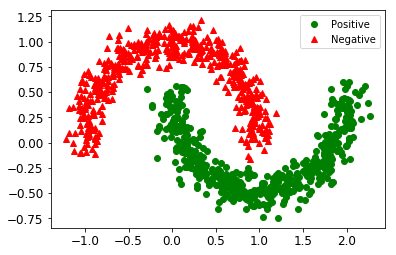

In [106]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

모든 샘플에 추가적인 편향 특성($x_0 = 1$)을 추가해야 합니다. 이렇게 하려면 입력 행렬 $\mathbf{X}$의 왼쪽에 1로 채워진 열을 추가해야 합니다:

In [107]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

확인해 보죠:

In [108]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

좋네요. 이제 `y_train`의 크기를 바꾸어 열 벡터로 만들겠습니다(즉, 하나의 열이 있는 2D 배열입니다):

In [109]:
y_moons_column_vector = y_moons.reshape(-1, 1)

이제 데이터셋을 훈련 세트와 테스트 세트로 나눕니다:

In [110]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

좋습니다. 이제 훈련 배치를 생성하기 위한 간단한 함수를 만들겠습니다. 이 함수는 각 배치를 위해 훈련 세트에서 랜덤하게 샘플을 선택합니다. 하나의 배치에 동일한 샘플이 여러번 들어갈 수 있고 한 번의 에포크에 모든 훈련 샘플이 포함되지 않을 수 있습니다(사실 샘플의 3분의 2 정도가 포함됩니다). 하지만 실전에서 별 문제가 되지 않고 코드가 간단해 집니다:

In [111]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

작은 배치 하나를 만들어 보겠습니다:

In [112]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [113]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

좋습니다! 모델에 주입할 데이터가 준비되었으므로 모델을 만들 차례입니다. 간단하게 시작해서 기능을 점차 추가해 보겠습니다.

먼저  기본 그래프를 리셋합니다.

In [114]:
reset_graph()

_moons_ 데이터셋은 두 개의 입력 특성을 가지므로 각 샘플은 평면 위의 한 점입니다(즉, 2차원입니다):

In [115]:
n_inputs = 2

로지스틱 회귀 모델을 만들어 보겠습니다. 4장에서 보았던 것처럼 이 모델은 먼저 (선형 회귀 모델과 동일하게) 입력의 가중치 합을 계산하고 그 결과를 시그모이드 함수에 적용하여 양성 클래스에 대한 추정 확률을 만듭니다:

$\hat{p} = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T \cdot \mathbf{x})$


$\mathbf{\theta}$는 편향 $\theta_0$와 가중치 $\theta_1, \theta_2, \dots, \theta_n$를 포함한 파라미터 벡터입니다. 입력 벡터 $\mathbf{x}$는 상수 항 $x_0 = 1$과 입력 특성 $x_1, x_2, \dots, x_n$을 포함합니다.

한 번에 여러 샘플에 대한 예측을 만들 수 있어야 하므로 하나의 입력 벡터보다는 입력 행렬 $\mathbf{X}$를 사용합니다. $i^{th}$ 번째 행이 $i^{th}$ 번째 입력 벡터의 전치$(\mathbf{x}^{(i)})^T$입니다. 다음 식을 사용하여 각 샘플이 양성 클래스에 속할 확률을 추정할 수 있습니다:

$ \hat{\mathbf{p}} = \sigma(\mathbf{X} \cdot \mathbf{\theta})$

모델을 만들기 위해 준비를 마쳤습니다:

In [116]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))

사실 텐서플로는 `tf.sigmoid()` 함수를 가지고 있어 마지막 라인을 다음과 같이 바꿀 수 있습니다:

In [117]:
y_proba = tf.sigmoid(logits)

4장에서 보았듯이 로그 손실은 로지스틱 회귀에 사용하기 좋은 비용 함수입니다:

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$

직접 구현하는 것도 한가지 방법입니다:

In [118]:
epsilon = 1e-7  # 로그를 계산할 때 오버플로우를 피하기 위해
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

하지만 텐서플로의 `tf.losses.log_loss()` 함수를 사용할 수 있습니다:

In [119]:
loss = tf.losses.log_loss(y, y_proba)  # 기본적으로 epsilon = 1e-7 가 사용됩니다

나머지는 아주 기본적입니다. 옵티마이저를 만들고 비용 함수를 최소화시키도록 합니다:

In [120]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

(이 간단한 예에서) 남은 것은 변수 초기화입니다:

In [121]:
init = tf.global_variables_initializer()

모델을 훈련하고 예측을 만들 준비가 되었습니다!

다음 코드에는 특별한 것은 없습니다. 앞서 선형 회귀에서 사용했던 것과 사실상 동일합니다:

In [122]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("에포크:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

에포크: 0 	Loss: 0.79260236
에포크: 100 	Loss: 0.3434635
에포크: 200 	Loss: 0.30754042
에포크: 300 	Loss: 0.29288897
에포크: 400 	Loss: 0.28533572
에포크: 500 	Loss: 0.2804781
에포크: 600 	Loss: 0.27808297
에포크: 700 	Loss: 0.27615443
에포크: 800 	Loss: 0.27551997
에포크: 900 	Loss: 0.27491236


노트: 배치를 만들 때 에포크 수를 사용하지 않았으므로 두 개의 `for` 반복을 중첩하지 않고 하나의 `for` 반복을 사용할 수 있습니다. 하지만 훈련 시간을 에포크의 개수로 생각하는게 편리합니다(즉, 알고리즘이 훈련 세트를 모두 훑고 지나가는 횟수).

테스트 세트에 있는 각 샘플에 대해서 `y_proba_val`은 해당 샘플이 양성 클래스에 속할 모델의 추정 확률을 담고 있습니다. 예를 들어 다음은 첫 번째 다섯 개 샘플의 추정 확률입니다:

In [123]:
y_proba_val[:5]

array([[0.54895616],
       [0.7072437 ],
       [0.51900256],
       [0.9911136 ],
       [0.50859046]], dtype=float32)

각 샘플을 분류하기 위해서 최대 가능도 방법(maximum likelihood)을 사용합니다. 추정 확률이 0.5보다 크거나 같으면 양성으로 분류합니다:

In [124]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

경우에 따라 0.5말고 다른 임계값을 사용해야 할 수 있습니다. 가령 높은 정밀도(대신 낮은 재현율)를 원한다면 임계값을 높이고 재현율을 높이려면(대신 낮은 정밀도) 임계값을 낮춥니다. 자세한 내용은 3장을 참고하세요.

모델의 정밀도와 재현율을 계산해 보겠습니다:

In [125]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8627450980392157

In [126]:
recall_score(y_test, y_pred)

0.8888888888888888

이 예측이 어떻게 보이는지 그래프로 나타내 보겠습니다:

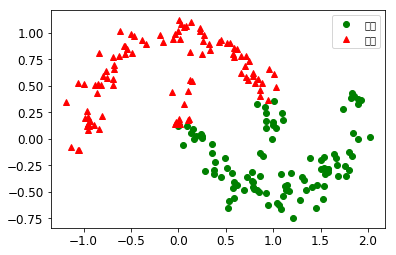

In [127]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터를 1차원 배열로 바꿉니다
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="양성")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="음성")
plt.legend()
plt.show()

음 결과가 좋지 않네요. 그렇죠? 하지만 로지스틱 회귀 모델은 선형적인 결정 경계를 가지므로 최선에 가까운 것 같습니다(잠시 후에 보겠지만 특성을 더 추가하지 않는다면 말이죠).

다시 시작해 보죠. 이번에는 연습문제에 나열된 모든 부가 기능을 추가해 보겠습니다:
* 재사용이 용이하도록 `logistic_regression()` 함수 안에서 그래프를 정의합니다.
* 훈련하는 동안 일정한 간격으로 `Saver` 객체를 사용해 체크포인트를 저장하고 훈련이 끝날 때 최종 모델을 저장합니다.
* 훈련이 중지되고 다시 시작할 때 마지막 체크포인트를 복원합니다.
* 텐서보드에서 그래프가 잘 정돈되어 보이도록 이름 범위를 사용하여 그래프를 정의합니다.
* 서머리(summary)를 추가해 텐서보드에서 학습 곡선을 나타냅니다.
* 학습률, 미니배치 크기 같은 하이퍼파라미터를 바꾸어 보면서 학습 곡선의 모양을 관찰합니다.

시작하기 전에 입력에 ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ 그리고 ${x_2}^3$ 네 개의 특성을 추가합니다. 연습문제에 포함되어 있지는 않지만 특성을 추가하면 모델의 성능이 향상되는 것을 확인할 수 있습니다. 여기서는 수동으로 특성을 추가하지만 `sklearn.preprocessing.PolynomialFeatures`을 사용할 수 있습니다.

In [128]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

특성이 추가된 훈련 세트는 다음과 같습니다:

In [129]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

좋습니다. 이제 기본 그래프를 초기화합니다:

In [130]:
reset_graph()

그래프를 만들기 위해 `logistic_regression()` 함수를 정의합니다. 입력 `X`와 타깃 `y`의 정의를 포함하지 않았습니다. 이 함수에서 정의할 수도 있지만 그렇게 하지 않아야 다양한 경우에 이 함수를 사용할 수 있습니다(예를 들어, 로지스틱 회귀 모델에 주입하기 전에 입력에 대해 전처리 단계를 추가할 수 있습니다).

In [131]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

텐서보드를 위해 서머리를 저장할 로그 디렉토리 이름을 생성하는 함수를 만듭니다:

In [132]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

이제 `logistic_regression()` 함수를 사용해 그래프를 만듭니다. 텐서보드용 서머리를 로그 디렉토리에 저장하기 위해 `FileWriter`도 만듭니다:

In [133]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

드디어 모델을 학습시킬 수 있습니다! 이전에 훈련 세션이 중지되었는지부터 검사하고 그렇다면 체크포인트를 로드하고 저장된 에포크 횟수부터 훈련을 이어갑니다. 이 예에서는 별도의 파일에 에포트 횟수를 저장했지만 11장에서 모델에 일부로 훈련 스텝을저장하는 방법을 배우겠습니다. 예를 들어 `global_step`이란 훈련되지 않는 변수를 옵티마이저의 `minimize()` 메서드에 전달합니다.

다시 시작할 때 마지막 체크포인트가 제대로 복원되는지 확인하기 위해 훈련을 중지시켜 볼 수 있습니다.

In [134]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # 체크포인트 파일이 있으면 모델을 복원하고 에포크 횟수를 로드합니다
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("중지되었던 훈련입니다. 에포크를 이어갑니다.", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("에포크:", epoch, "\t손실:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

에포크: 0 	손실: 0.62998503
에포크: 500 	손실: 0.16122366
에포크: 1000 	손실: 0.11903212
에포크: 1500 	손실: 0.097329214
에포크: 2000 	손실: 0.083697945
에포크: 2500 	손실: 0.07437584
에포크: 3000 	손실: 0.067502156
에포크: 3500 	손실: 0.06220691
에포크: 4000 	손실: 0.058026787
에포크: 4500 	손실: 0.05456298
에포크: 5000 	손실: 0.051708277
에포크: 5500 	손실: 0.04923773
에포크: 6000 	손실: 0.047167283
에포크: 6500 	손실: 0.045376636
에포크: 7000 	손실: 0.043818742
에포크: 7500 	손실: 0.042374216
에포크: 8000 	손실: 0.041089155
에포크: 8500 	손실: 0.039970912
에포크: 9000 	손실: 0.038920246
에포크: 9500 	손실: 0.038010743
에포크: 10000 	손실: 0.0371557


여기에서도 추정 확률이 0.5보다 크거나 같은 샘플을 모두 양성으로 분류하면 예측이 됩니다:

In [135]:
y_pred = (y_proba_val >= 0.5)

In [136]:
precision_score(y_test, y_pred)

0.9797979797979798

In [137]:
recall_score(y_test, y_pred)

0.9797979797979798

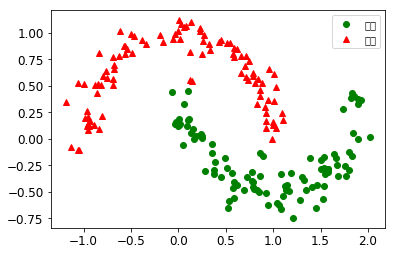

In [138]:
y_pred_idx = y_pred.reshape(-1) # 열 벡터 대신 1차원 배열
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="양성")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="음성")
plt.legend()
plt.show()

훨씬 더 좋아졌네요! 새로 추가한 특성이 확실히 도움이 많이 되었습니다.

텐서보드 서버를 시작해서 최근 실행을 찾아 학습 곡선을 확인해 보세요(즉, 에포크 횟수에 대해 테스트 세트로 평가한 손실이 얼마나 되는지):

```
$ tensorboard --logdir=tf_logs
```

이제 하이퍼파라미터(가령, `batch_size`나 `learning_rate`)를 조정하면서 훈련을 여러번 실행해 보고 학습 곡선을 비교해 보겠습니다. 그리드 서치나 랜덤 서치를 구현해서 이 과정을 자동화할 수도 있습니다. 다음은 배치 크기와 학습률에 대한 간단한 랜덤 서치 구현입니다. 간단하게 하기 위해서 체크포인트 관리 부분은 제외했습니다.

In [139]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("반복", search_iteration)
    print("  logdir:", logdir)
    print("  batch_size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  훈련: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  정밀도:", precision_score(y_test, y_pred))
        print("  재현율:", recall_score(y_test, y_pred))

반복 0
  logdir: tf_logs/logreg-run-20180405072916/
  batch_size: 54
  learning_rate: 0.004430375245218265
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 1
  logdir: tf_logs/logreg-run-20180405073454/
  batch_size: 22
  learning_rate: 0.0017826497151386947
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 2
  logdir: tf_logs/logreg-run-20180405074502/
  batch_size: 74
  learning_rate: 0.00203228544324115
  훈련: .....................
  정밀도: 0.9696969696969697
  재현율: 0.9696969696969697
반복 3
  logdir: tf_logs/logreg-run-20180405074813/
  batch_size: 58
  learning_rate: 0.004491523825137997
  훈련: .....................
  정밀도: 0.9797979797979798
  재현율: 0.9797979797979798
반복 4
  logdir: tf_logs/logreg-run-20180405075337/
  batch_size: 61
  learning_rate: 0.07963234721775589
  훈련: .....................
  정밀도: 0.9801980198019802
  재현율: 1.0
반복 5
  logdir: tf_logs/logreg-run-20180405075839/
  batch_size: 92
  learning_rate: 0.00046

하이퍼파라미터의 적절한 스케일을 감잡을 수 없을 때 사이파이(SciPy)의 `stats` 모듈의 `reciprocal()` 함수를 사용하여 난수 분포를 얻을 수 있습니다. 좀 더 자세한 내용은 2장의 연습문제 해답을 보세요.